I've been interested in using machine learning to understand more about dating habits. Fortunately, I found a dataset on OKCupid collected by Kirkegaard and Bjerrekaer (https://figshare.com/articles/dataset/OKCupid_Datasets/14987388). It features 68371 records with information collected on how they've answered questions and some innate scores that OKCupid gives each profile. There's already been plenty of work done regarding this dataset, so I want to focus on something more niche.

To start, the data is present in two files; one file for question indexes and one with the indexed data. Let's load the data in!

In [81]:
# Imports first as usual
import pandas as pd
from sklearn.cluster import Birch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import optuna
import shap
import matplotlib
from IPython.display import display
import matplotlib.pyplot as plt

data = pd.read_parquet("D:\\portfolio\\data\\parsed_data_public.parquet")
questions = pd.read_csv("D:\\portfolio\\data\\question_data.csv", delimiter=";", index_col=0)
data.set_index("Unnamed: 0", inplace = True)
display(data.head())
display(data.shape)
display(questions.head())
display(questions.shape)

,q2,q11,q12,q13,q14,q16,q17,q18,q20,q22,...,q86615,q86699,q363047,CA,gender_orientation,gender,race,gender2,gender2_num,CA_items
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,None,Horrified,None,None,None,None,No,None,None,None,...,None,None,None,0.763080,Hetero_female,Woman,White,Woman,0.0,4
2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,NaN,Hetero_male,Man,None,Man,1.0,0
3,None,None,None,No,No,None,No,None,None,None,...,None,None,None,0.661309,Hetero_female,Woman,None,Woman,0.0,7
4,None,None,None,None,None,None,None,None,None,None,...,None,None,None,NaN,Hetero_female,Woman,White,Woman,0.0,0
5,None,None,None,None,None,None,None,None,None,None,...,None,None,None,0.875424,Bisexual_female,Woman,None,Woman,0.0,3


(68371, 2625)

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,NaN,sex/intimacy; preference; opinion
q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,NaN,sex/intimacy
q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,NaN,sex/intimacy
q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,NaN,sex/intimacy
q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,NaN,sex/intimacy


(2620, 9)

There are quite a lot of questions - 2620! Let's get some more information on what the questions look like.

In [82]:
keywords = set(questions.Keywords)
keywords.remove(np.NaN)
print(keywords)

{'religion/superstition; opinion', 'politics; preference; descriptive', 'politics; religion/superstition; descriptive', 'sex/intimacy; preference', 'sex/intimacy; preference; descriptive', 'politics; opinion; cognitive', 'politics; preference', 'sex/intimacy; opinion', 'sex/intimacy; preference; BDSM', 'politics; sex/intimacy; religion/superstition; opinion', 'sex/intimacy; preference; opinion', 'religion/superstition', 'preference; descriptive', 'descriptive; technology', 'politics; religion/superstition; opinion', 'sex/intimacy; religion/superstition', 'descriptive; cognitive', 'sex/intimacy; descriptive', 'sex/intimacy; religion/superstition; opinion', 'sex/intimacy', 'sex/intimacy; religion/superstition; descriptive', 'politics; religion/superstition', 'politics; sex/intimacy; descriptive', 'politics', 'politics; opinion; technology', 'descriptive', 'politics; descriptive; preference', 'descriptive; opinion', 'politics; preference; opinion; sex/intimacy', 'politics; sex/intimacy; r

There are some themes amongst the questions. I'm most interested in how politics influences some of the descriptive traits that OKCupid has gathered. To reduce the number of features we're fitting with, I'll only select to top 5 most answered politics questions.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68371 entries, 1 to 68371
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   q179268  54202 non-null  object
 1   q403     52369 non-null  object
 2   q175     45720 non-null  object
 3   q212813  45107 non-null  object
 4   q612     44907 non-null  object
dtypes: object(5)
memory usage: 3.1+ MB


None

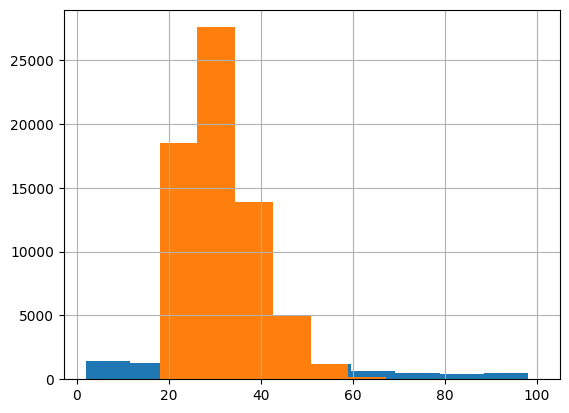

In [83]:
politics = [x for x in keywords if x.startswith("politics")]
question_subset = questions[questions["Keywords"].isin(politics)]
top_5_politics = question_subset.sort_values("N", ascending=False).iloc[0:5]
data["p_honest"].hist()
data["d_age"].hist()
display(data[top_5_politics.index].info())

The descriptive properties are denoted with "p_". We can take a look at all of the potential targets to use politics questions to predict.

In [84]:
descriptives = [column for column in data.columns if column.startswith("p_")]
print(descriptives)

['p_conf', 'p_laidback', 'p_drug', 'p_lit', 'p_progress', 'p_roman', 'p_dominant', 'p_polit', 'p_pure', 'p_manners', 'p_submissive', 'p_inde', 'p_kinky', 'p_opti', 'p_sloppy', 'p_indie', 'p_introvert', 'p_arro', 'p_ambi', 'p_cool', 'p_trusting', 'p_thrift', 'p_organ', 'p_sexdrive', 'p_honest', 'p_expsex', 'p_artsy', 'p_scien', 'p_spon', 'p_explife', 'p_greed', 'p_capi', 'p_giving', 'p_explove', 'p_convenmoral', 'p_aggre', 'p_kind', 'p_extro', 'p_friendstrangers', 'p_oldfash', 'p_comp', 'p_lovedri', 'p_sprit', 'p_passion', 'p_energetic', 'p_exer', 'p_logic', 'p_math', 'p_geeky', 'p_adven']


I'm planning to fit the political questions on these features. It would be interesting to see the relationship between "p_honest" and political questions. Let's fit an XGBoost model that attempts to predict the honesty score from one's political question answers. Let's set the target, subset the data and get it ready for the model. The features are all nominal or ordinal, we'll need to encode them prior to fitting.

In [85]:
features = top_5_politics.index.tolist()
target = ["p_honest"]
subset_data = data[features + target]
subset_data = subset_data[subset_data[target].notna().values]
ohe = OneHotEncoder(sparse=False, drop="first")
inputs = ohe.fit_transform(subset_data[features])


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Now that we've got our data pipeline created, we can split the data into test/train set and find a few success metrics to judge the fit. I personally prefer MSE, but I'll include a few others too.

In [86]:
xtrain, xtest, ytrain, ytest = train_test_split(inputs, subset_data[target], random_state=1)


xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(xtrain, ytrain)
predictions = xgb_regressor.predict(xtest)
predictions - ytest.values
mse = mean_squared_error(ytest.values, predictions)
r2 = r2_score(ytrain.values, xgb_regressor.predict(xtrain))
adj_r2 = 1-(1-r2)*(xtrain.shape[0]-1)/(xtrain.shape[0]-xtrain.shape[1]-1)
absolute_average_error = np.mean(abs(ytest.values - predictions))
paae = absolute_average_error/np.mean(ytest.values)

print("mse: %f" % mse)
print("adj_r2: %f" % adj_r2)
print("percent absolute average error: %f" % paae)


mse: 709.685552
adj_r2: 0.075969
percent absolute average error: 0.600686


These results are not as exciting as I'd have hoped! The percent absolute average error is rather high. The RMSE is also very high for a number that's bounded between 0 and 100. To remedy this, let's create a hyper parameter optimiser to tune some of the XGBoost parameters. We'll split out our data into a set we can tune, then get our final fit metrics with the rest.

My library of choice right now for optimisation is Optuna (https://optuna.org/). It's an incredibly accessible library with some pretty cool optimisation methods.

In [87]:
hpo_data = subset_data.iloc[:int(subset_data.shape[0]/3)]
modelling_data = subset_data.iloc[int(subset_data.shape[0]/3):]

hpo_inputs = ohe.fit_transform(hpo_data[features])
hpox_train, hpox_test, hpo_ytrain, hpo_ytest = train_test_split(hpo_inputs, hpo_data[target], random_state=1)
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    eta = trial.suggest_float("eta", 0.0001, 0.01)
    gamma = trial.suggest_float("gamma", 0, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    xgb_regressor = xgb.XGBRegressor(eta=eta, gamma=gamma, max_depth=max_depth, random_state=1)
    xgb_regressor.fit(hpox_train, hpo_ytrain)
    predictions = xgb_regressor.predict(hpox_test)
    mse = mean_squared_error(hpo_ytest.values, predictions)
    return mse 

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=1000)  # Invoke optimization of the objective function.
# fig = optuna.visualization.plot_contour(study, params=["eta", "gamma"])
# fig.show()
best_mse = study.best_trial.values[0]
improvement = abs(best_mse - mse) / mse

print("best_mse %f" % best_mse)
print("mse improvement %f" % improvement)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
[I 2022-12-27 18:59:48,049] A new study created in memory with name: no-name-c0da0162-f0cc-4132-90e8-e69e24c1a894
[I 2022-12-27 18:59:48,125] Trial 0 finished with value: 1842.4048648073574 and parameters: {'eta': 0.0035247359097919043, 'gamma': 825.8561526357634, 'max_depth': 10}. Best is trial 0 with value: 1842.4048648073574.
[I 2022-12-27 18:59:48,157] Trial 1 finished with value: 1582.3569160509473 and parameters: {'eta': 0.0048819864514167656, 'gamma': 698.9476986059406, 'max_depth': 3}. Best is trial 1 with value: 1582.3569160509473.
[I 2022-12-27 18:59:48,214] Trial 2 finished with value: 2020.2835601967834 and parameters: {'eta': 0.0027591801789475677, 'gamma': 848.4299600695483, 'max_depth': 7}. Best is trial 1 with value: 1582.3569160509473.
[I 2022-12-27 18:59:48,270] Trial 3 finished with value: 2337.2459073702607 and

best_mse 1054.248830
mse improvement 0.485515


The improvement is pretty good overall! Almost 14% better than without the hyper parameter selection. However, the important test will be whether our modelling data set performs better than the model we fit prior to the parameter selection.

In [88]:

hpo_inputs = ohe.fit_transform(modelling_data[features])
hpox_train, hpox_test, hpo_ytrain, hpo_ytest = train_test_split(hpo_inputs, modelling_data[target])

xgb_regressor = xgb.XGBRegressor(**study.best_trial.params)
xgb_regressor.fit(hpox_train, hpo_ytrain)
predictions = xgb_regressor.predict(hpox_test)
predictions - hpo_ytest.values
mse_optim = mean_squared_error(hpo_ytest.values, predictions)
final_mse = abs(mse - mse_optim) / mse
print("optimal mse: %f" % mse_optim)
print("final mse improvement: %f" % final_mse)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


optimal mse: 823.486931
final mse improvement: 0.160355


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


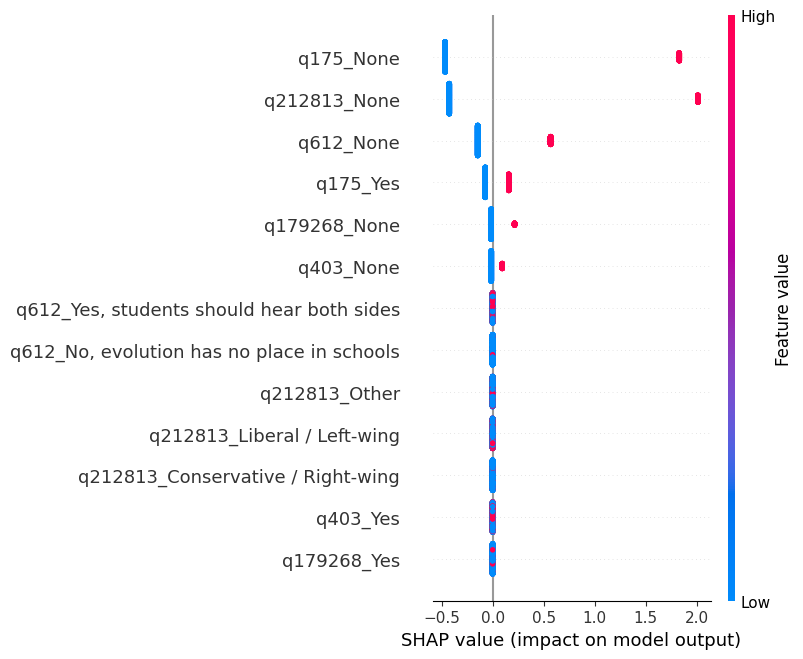

In [89]:
feature_names = modelling_data.columns
explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(hpox_test)
shap.summary_plot(shap_values, hpox_test, feature_names = ohe.get_feature_names_out())


In [90]:
q_labels = list(enumerate(top_5_politics.index))
q_enums = [[x.split("_")[0], index] for index, x in enumerate(ohe.get_feature_names_out())]
combined_shap = []
for q in top_5_politics.index:
    cols = [x[1] for x in q_enums if x[0] == q]
    combined_shap.append(shap_values[:,cols].sum(axis=1))
end_shap = np.array(combined_shap).T
# shap_values

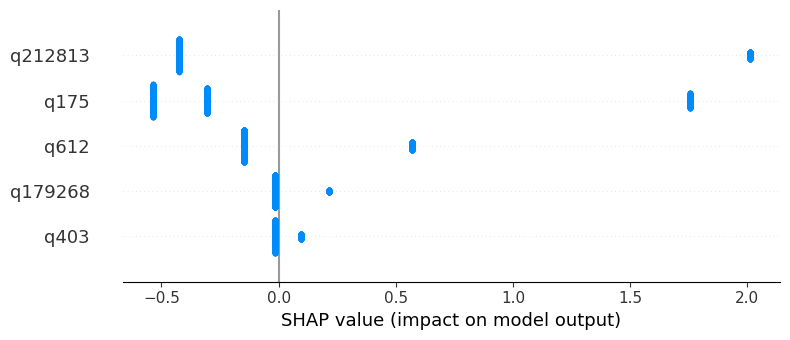

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q179268,Are you either vegetarian or vegan?,Yes,No,NaN,NaN,54202,O,NaN,politics; descriptive
q403,Do you enjoy discussing politics?,Yes,No,NaN,NaN,52369,O,NaN,politics; preference; descriptive
q175,Should burning your country's flag be illegal?,Yes,No,NaN,NaN,45720,O,NaN,politics
q212813,Which best describes your political beliefs?,Liberal / Left-wing,Centrist,Conservative / Right-wing,Other,45107,M,[4],politics; descriptive
q612,Should evolution and creationism be taught sid...,"Yes, students should hear both sides","No, creationism has no place in schools","No, evolution has no place in schools",NaN,44907,O,"2, 1, 3",politics; religion/superstition


In [91]:
shap.summary_plot(end_shap, feature_names = top_5_politics.index)
questions.loc[top_5_politics.index]